In [ ]:
from google.colab import files


uploaded = files.upload()


In [ ]:
import pandas as pd

In [ ]:
weather = pd.read_csv('3568677.csv', index_col="DATE")

In [ ]:
weather

In [ ]:
weather.apply(pd.isnull).sum()/weather.shape[0]

In [ ]:
core_weather = weather[["PRCP", "TMAX", "TMIN"]].copy()
core_weather.columns = ["precip", "temp_max", "temp_min"]

In [ ]:
core_weather.apply(pd.isnull).sum()

In [ ]:
core_weather["precip"].value_counts() / core_weather.shape[0]


In [ ]:
core_weather["precip"] = core_weather["precip"].fillna(0)


In [ ]:
core_weather.apply(pd.isnull).sum()


In [ ]:
core_weather = core_weather.fillna(method="ffill")


In [ ]:
core_weather.apply(pd.isnull).sum()


In [ ]:
core_weather.loc["2011-12-18":"2011-12-28"]


In [ ]:
core_weather = core_weather.fillna(method="ffill")


In [ ]:
core_weather.apply(pd.isnull).sum()


In [ ]:
core_weather.apply(lambda x: (x == 9999).sum())


In [ ]:
core_weather.index = pd.to_datetime(core_weather.index)



In [ ]:
core_weather.index


In [ ]:
core_weather.index.year


<Axes: xlabel='DATE'>

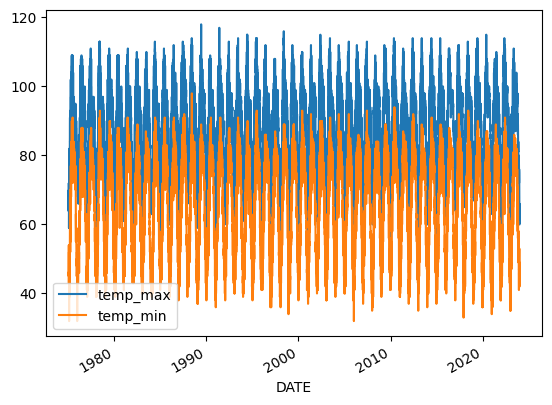

In [ ]:
core_weather[["temp_max", "temp_min"]].plot()


In [ ]:
core_weather.index.year.value_counts().sort_index()


1975    355
1976    359
1977    365
1978    365
1979    365
1980    366
1981    365
1982    365
1983    365
1984    364
1985    365
1986    365
1987    364
1988    359
1989    363
1990    349
1991    356
1992    311
1993    363
1994    361
1995    364
1996    366
1997    365
1998    363
1999    362
2000    366
2001    364
2002    364
2003    365
2004    366
2005    365
2006    365
2007    362
2008    366
2009    365
2010    361
2011    360
2012    366
2013    365
2014    365
2015    365
2016    365
2017    363
2018    365
2019    361
2020    366
2021    362
2022    365
2023    363
2024      9
Name: DATE, dtype: int64

<Axes: xlabel='DATE'>

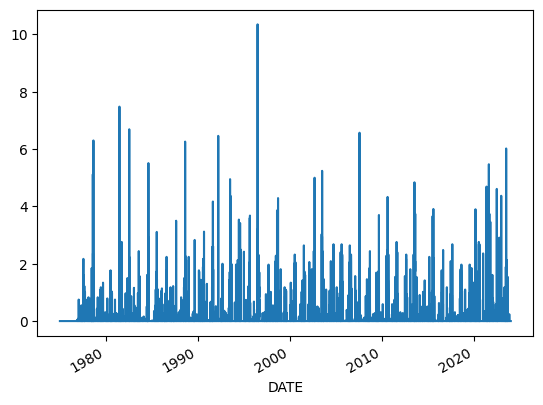

In [ ]:
 core_weather["precip"].plot()


In [ ]:
core_weather["target"] = core_weather.shift(-1)["temp_max"]

core_weather



,precip,temp_max,temp_min,target
DATE,,,,
1975-01-10,0.0,64.0,46.0,66.0
1975-01-11,0.0,66.0,46.0,68.0
1975-01-12,0.0,68.0,46.0,68.0
1975-01-13,0.0,68.0,46.0,70.0
1975-01-14,0.0,70.0,45.0,64.0
...,...,...,...,...
2024-01-05,0.0,60.0,49.0,60.0
2024-01-06,0.0,60.0,49.0,60.0
2024-01-07,0.0,60.0,49.0,66.0


In [ ]:
core_weather = core_weather.iloc[:-1,:].copy()


In [ ]:
from sklearn.linear_model import Ridge

reg = Ridge(alpha=.1)

In [ ]:
predictors = ["precip", "temp_max", "temp_min"]


In [ ]:
train = core_weather.loc[:"2020-12-31"]
test = core_weather.loc["2021-01-01":]

In [ ]:
train


In [ ]:
test

In [ ]:
reg.fit(train[predictors], train["target"])


Ridge(alpha=0.1)

In [ ]:
predictions = reg.predict(test[predictors])


In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error(test["target"], predictions)

8.680808510772883

In [ ]:
combined = pd.concat([test["target"], pd.Series(predictions, index=test.index)], axis=1)
combined.columns = ["actual", "predictions"] #converts it from numpy to pandas series and shows actual vs prediction

In [ ]:
combined


,actual,predictions
DATE,,
2021-01-01,67.0,65.404541
2021-01-02,67.0,67.931723
2021-01-03,67.0,68.732862
2021-01-04,73.0,68.754000
2021-01-05,69.0,74.108365
...,...,...
2024-01-04,60.0,61.777756
2024-01-05,60.0,61.982148
2024-01-06,60.0,61.982148


<Axes: xlabel='DATE'>

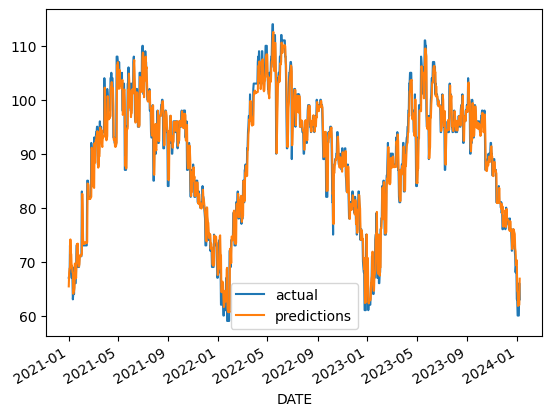

In [ ]:
combined.plot()


In [ ]:
reg.coef_

array([0.46988234, 0.88887111, 0.06813085])

In [ ]:
core_weather["month_max"] = core_weather["temp_max"].rolling(30).mean()

core_weather["month_day_max"] = core_weather["month_max"] / core_weather["temp_max"]

core_weather["max_min"] = core_weather["temp_max"] / core_weather["temp_min"]

In [ ]:
core_weather = core_weather.iloc[30:,:].copy()


In [ ]:
def create_predictions(predictors, core_weather, reg):
    train = core_weather.loc[:"2020-12-31"]
    test = core_weather.loc["2021-01-01":]

    reg.fit(train[predictors], train["target"])
    predictions = reg.predict(test[predictors])

    error = mean_squared_error(test["target"], predictions)

    combined = pd.concat([test["target"], pd.Series(predictions, index=test.index)], axis=1)
    combined.columns = ["actual", "predictions"]
    return error, combined


In [ ]:
predictors = ["precip", "temp_max", "temp_min", "month_day_max", "max_min"]

error, combined = create_predictions(predictors, core_weather, reg)
error

8.657821719329478

<Axes: xlabel='DATE'>

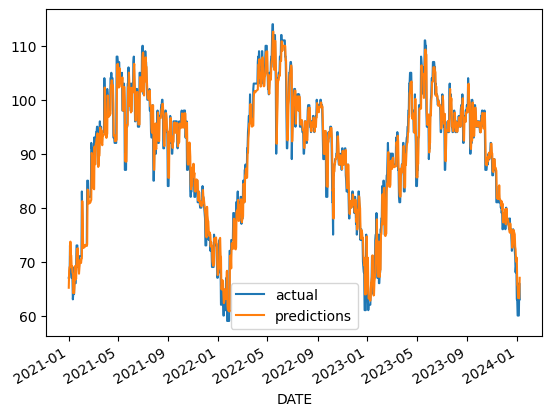

In [ ]:
combined.plot()

In [ ]:
core_weather["monthly_avg"] = core_weather["temp_max"].groupby(core_weather.index.month).apply(lambda x: x.expanding(1).mean())
core_weather["day_of_year_avg"] = core_weather["temp_max"].groupby(core_weather.index.day_of_year).apply(lambda x: x.expanding(1).mean())

<ipython-input-47-33e63cccf9b3>:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  core_weather["monthly_avg"] = core_weather["temp_max"].groupby(core_weather.index.month).apply(lambda x: x.expanding(1).mean())
<ipython-input-47-33e63cccf9b3>:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  core_w

In [ ]:
error, combined = create_predictions(predictors + ["monthly_avg", "day_of_year_avg"], core_weather, reg)
error

8.393197887279262

In [ ]:
reg.coef_

array([ 0.0836035 ,  0.7482556 , -0.00237243, -0.08214091,  0.09386406,
        0.07015147,  0.18942256])

In [ ]:
core_weather.corr()["target"]

precip             0.007056
temp_max           0.958187
temp_min           0.854046
target             1.000000
month_max          0.870068
month_day_max     -0.343470
max_min           -0.484797
monthly_avg        0.894316
day_of_year_avg    0.916210
Name: target, dtype: float64

In [ ]:
combined["diff"] = (combined["actual"] - combined["predictions"]).abs()


In [ ]:
combined.sort_values("diff", ascending=False).head(10)


,actual,predictions,diff
DATE,,,
2022-06-30,89.0,104.620277,15.620277
2021-05-18,87.0,101.405968,14.405968
2021-04-28,108.0,94.267587,13.732413
2022-05-23,90.0,103.478892,13.478892
2022-12-29,75.0,63.419772,11.580228
2021-02-15,85.0,73.537341,11.462659
2022-09-22,82.0,93.428100,11.428100
2021-02-02,83.0,71.613387,11.386613
2021-02-25,92.0,81.031641,10.968359
